## Init Azure OpenAI client and define a function to get model responses from text-only prompt

In [2]:
import os
from openai import AzureOpenAI
from dotenv import load_dotenv
from IPython.display import clear_output
clear_output()

In [3]:
load_dotenv()

# Initialize Azure OpenAI client
client = AzureOpenAI(
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("AZURE_OPENAI_API_VERSION"),
)

# Example usage of the client with the Chat Completions API and a text-only prompt
def text_prompt(prompt) -> str:
    """    
    Function to get model responses from a text-only prompt.

    Args:
        prompt (str): The text prompt to send to the model.
    Returns:
        str: The model's response text.
    """
    response = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant. Only answer the question. Don't format in markdown your response."
            },
            {
                "role": "user",
                "content": prompt
            }
        ],
    )
    return response.choices[0].message.content

In [4]:
prompt = "What is the capital of France?"
print(text_prompt(prompt))

The capital of France is Paris.


## Explore Stanford Dogs dataset and plot breed distribution

We will use the Stanford Dogs dataset, introduced by Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao and Li Fei-Fei. Novel dataset for Fine-Grained Image Categorization. First Workshop on Fine-Grained Visual Categorization (FGVC), IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2011.

This dataset contains 20,580 images of 120 breeds of dogs from around the world.

In order to use the Stanford Dogs dataset, we need to download it and extract the images. The dataset can be downloaded from Kaggle or directly from the Stanford Dogs website. I'm going to use the Kaggle API to download the dataset. Make sure you have the Kaggle API installed and configured with your credentials.

### Download and unzip dataset

In [9]:
from pathlib import Path
import os, json

# Path to the Kaggle token file
creds_path = Path(".kaggle/kaggle.json")

# Read the two fields and export them as env-vars
with creds_path.open() as f:
    creds = json.load(f)

os.environ["KAGGLE_USERNAME"] = creds["username"]
os.environ["KAGGLE_KEY"]      = creds["key"]

In [5]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset -p .

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other




  0%|          | 0.00/750M [00:00<?, ?B/s]
 12%|█▏        | 87.0M/750M [00:00<00:00, 907MB/s]
 24%|██▍       | 181M/750M [00:00<00:00, 921MB/s] 
 38%|███▊      | 284M/750M [00:00<00:00, 978MB/s]
 50%|█████     | 378M/750M [00:00<00:00, 945MB/s]
 62%|██████▏   | 469M/750M [00:00<00:00, 879MB/s]
 74%|███████▍  | 554M/750M [00:00<00:00, 867MB/s]
 85%|████████▌ | 638M/750M [00:00<00:00, 851MB/s]
 96%|█████████▌| 720M/750M [00:01<00:00, 359MB/s]
100%|██████████| 750M/750M [00:01<00:00, 578MB/s]


In [6]:
# now unzip it
import zipfile
with zipfile.ZipFile("stanford-dogs-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("stanford_dogs_dataset/")

# remove the zip file
os.remove("stanford-dogs-dataset.zip")

Now that we have the dataset downloaded, let's only keep the images and remove the annotations that we won't need in our classification task.

In [7]:
import shutil
shutil.rmtree("stanford_dogs_dataset/annotations")

### Let's have a look at the breed distribution across the dataset

In [5]:
import pathlib
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

def extract_breed_from_folder(name: str) -> str:
    # Stanford Dogs folder names are like "n02085620-Chihuahua"
    # Split on '-' and take the part after, or fallback to full name.
    parts = name.split('-', 1)
    breed_name = parts[1] if len(parts) == 2 else name
    
    # Data cleansing: remove underscores and capitalize properly
    # Example: "wire-haired_fox_terrier" -> "Wire-haired fox terrier"
    breed_name = breed_name.replace('_', ' ')  # Replace underscores with spaces
    breed_name = breed_name.title()  # Capitalize first letter of each word
    
    return breed_name

def count_images_per_breed(root_dir: pathlib.Path, extensions=(".jpg", ".jpeg", ".png")) -> pd.DataFrame:
    """
    Scans subdirectories of root_dir, counts image files per breed.
    Returns a DataFrame with columns: breed, count, pct.
    """
    counter = Counter()
    for breed_dir in root_dir.iterdir():
        if not breed_dir.is_dir():
            continue
        breed_name = extract_breed_from_folder(breed_dir.name)
        # Count image files
        num = sum(1 for p in breed_dir.iterdir() if p.suffix.lower() in extensions and p.is_file())
        counter[breed_name] = num

    df = pd.DataFrame.from_records(
        [(breed, cnt) for breed, cnt in counter.items()],
        columns=["breed", "count"]
    )
    df = df.sort_values("count", ascending=False).reset_index(drop=True)
    total = df["count"].sum()
    df["pct"] = df["count"] / total * 100
    return df


def plot_breed_distribution(
    df, 
    log_scale: bool = False, 
    as_percentage: bool = False, 
    annotate: bool = True
):
    """
    Plot all breeds (no grouping) as a horizontal bar chart.
    df: DataFrame with columns ['breed', 'count', 'pct'], sorted descending by count.
    log_scale: if True, x-axis is log-scaled.
    as_percentage: if True, use percentage (pct) instead of raw count.
    annotate: whether to put numeric labels on bars (can be turned off if too crowded).
    """
    plot_df = df.copy()
    x = plot_df["breed"]
    y = plot_df["pct"] if as_percentage else plot_df["count"]

    # Dynamic height: e.g., 0.25 inch per breed (tunable)
    height_per_breed = 0.25
    fig_height = max(6, height_per_breed * len(plot_df))
    fig, ax = plt.subplots(figsize=(10, fig_height))

    bars = ax.barh(x[::-1], y[::-1])  # largest on top

    xlabel = "Percentage (%)" if as_percentage else "Image Count"
    if log_scale:
        ax.set_xscale("log")
        xlabel = "Log-scaled " + xlabel

    ax.set_xlabel(xlabel)
    ax.set_title(
        f"Breed Distribution — all {len(plot_df)} breeds "
        f"({'percentage' if as_percentage else 'count'})"
    )

    # Improve readability
    ax.tick_params(axis="y", labelsize=7)
    plt.tight_layout()

    if annotate:
        max_val = max(y)
        for bar in bars:
            width = bar.get_width()
            if as_percentage:
                label = f"{width:.1f}%"
            else:
                label = f"{int(width)}"
            # Offset based on scale (if log, annotation logic can be adjusted)
            offset = 0.01 * (max_val if not log_scale else width)
            ax.text(
                width + offset, 
                bar.get_y() + bar.get_height() / 2,
                label,
                va="center",
                fontsize=6
            )

    plt.tight_layout()
    plt.show()

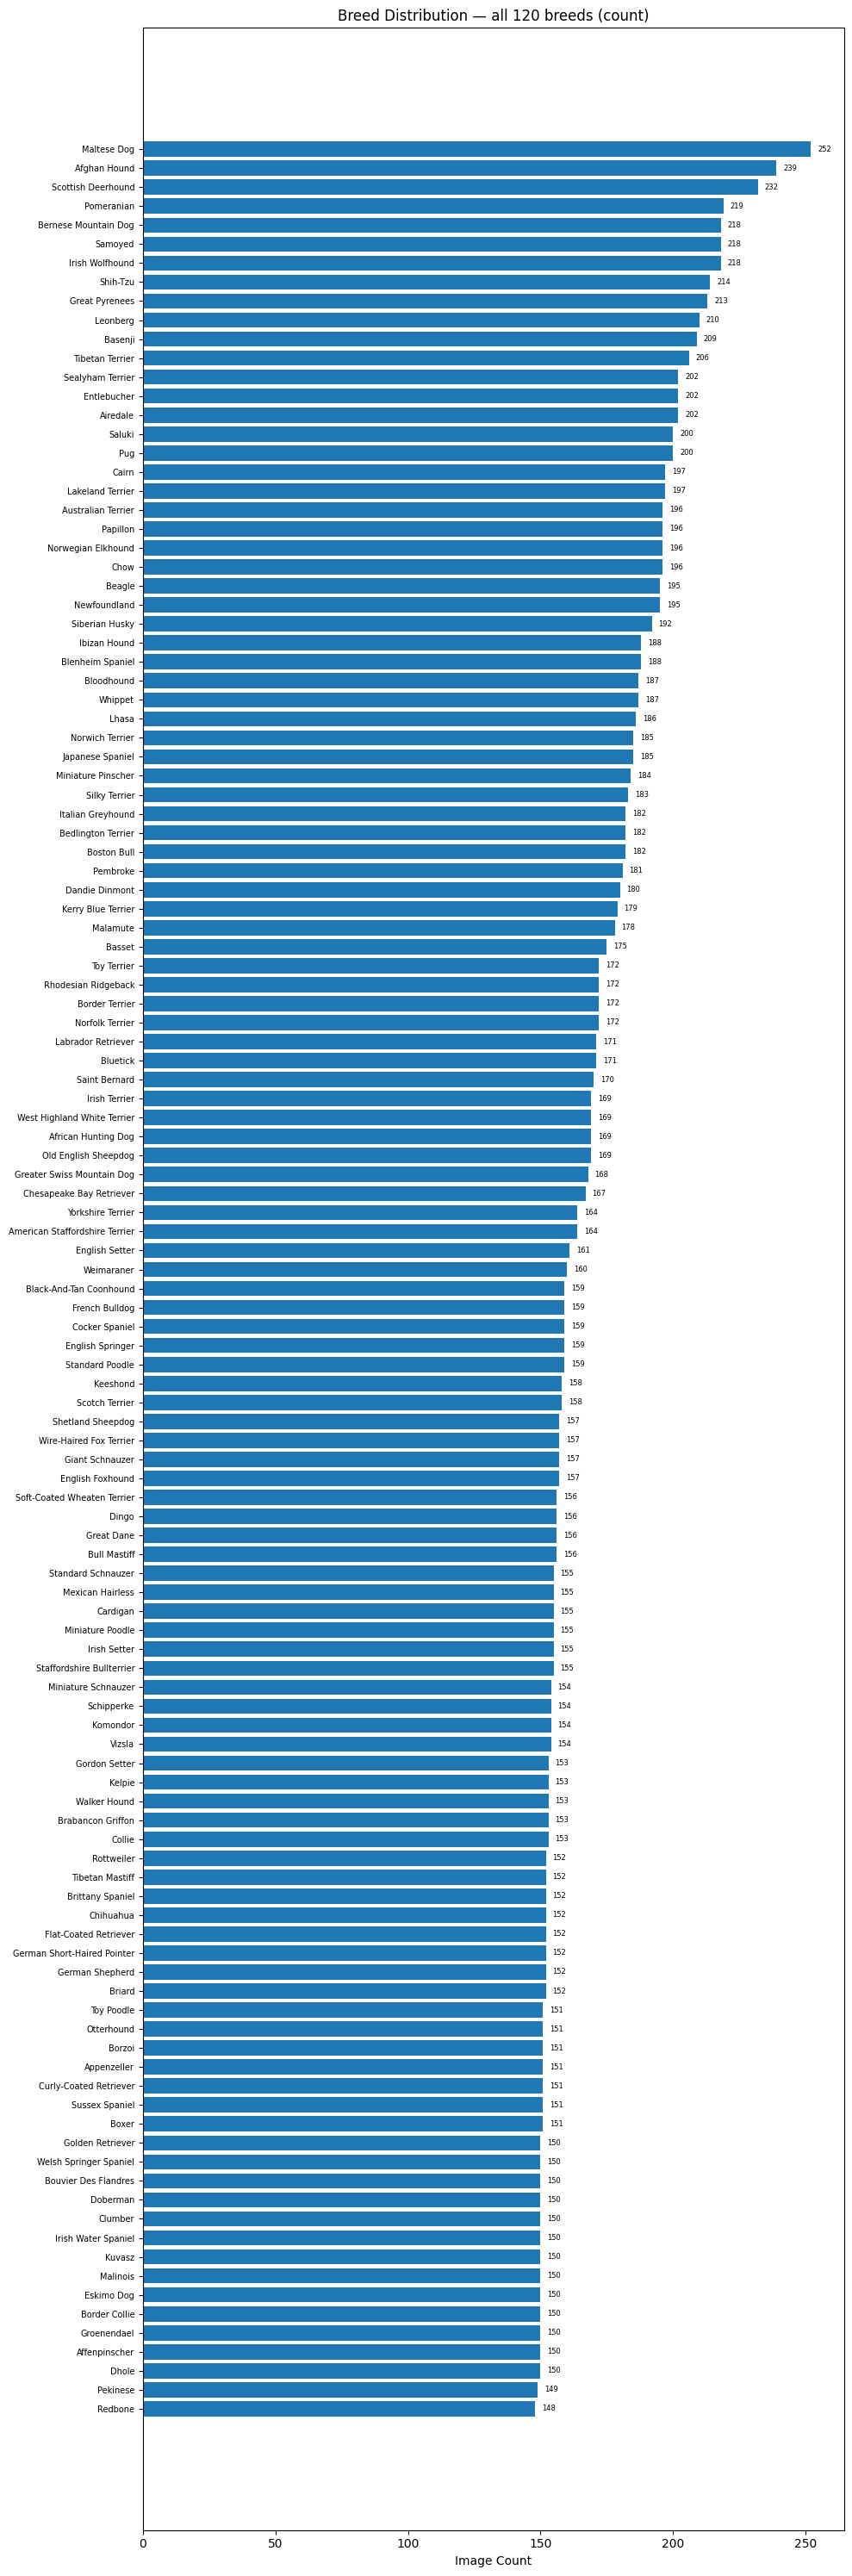

In [6]:
df = count_images_per_breed(pathlib.Path("./stanford_dogs_dataset/images/Images"))
plot_breed_distribution(df, log_scale=False, as_percentage=False) 

As we can see, the dataset is quite balanced across breeds, with breeds having between 148 (minimum) and 252 (maximum) samples. 

However, for the sake of cost management, we will limit the dataset to 50 images per breed. This is a reasonable compromise that still allows us to train a model with a good amount of data while keeping costs manageable.

## Split dataset into training, validation and test sets

In [10]:
import numpy as np

root_dir = Path() / "stanford_dogs_dataset" / "images" / "Images"
data = []
for d in root_dir.iterdir():
    if not d.is_dir():
        continue
    data.extend([{"label": d.name, "img_path": p} for p in d.iterdir()])

dataset_df = pd.DataFrame(data)
classes = [*dataset_df["label"].unique()]
dataset_df.head()

,label,img_path
0,n02085620-Chihuahua,stanford_dogs_dataset\images\Images\n02085620-...
1,n02085620-Chihuahua,stanford_dogs_dataset\images\Images\n02085620-...
2,n02085620-Chihuahua,stanford_dogs_dataset\images\Images\n02085620-...
3,n02085620-Chihuahua,stanford_dogs_dataset\images\Images\n02085620-...
4,n02085620-Chihuahua,stanford_dogs_dataset\images\Images\n02085620-...


In [11]:
import pandas as pd
from pathlib import Path
import base64

# 1. Clean up the class names
# -------------------------------------------------
dataset_df["breed"] = (
    dataset_df["label"]
    .str.split("-", n=1).str[1]             # take text after the first “-”
    .str.replace("_", " ", regex=False)     # _ → space
    .str.title()                            # African Hunting Dog, Chihuahua, …
)

# 2. Keep the first 50 images per breed
# --------------------------------------------------------
N_PER_BREED = 50
dataset_trimmed = (
    dataset_df
    .sort_values(["breed", "img_path"])         # keep original order inside each breed
    .groupby("breed", as_index=False)
    .head(N_PER_BREED)                          # NOT random, just first 50
    .reset_index(drop=True)
)

# 3. Split into train / val / test (0.8 / 0.1 / 0.1)
# --------------------------------------------------------
def assign_split(idx):
    """idx: 0-based position inside its breed (0-49)"""
    if idx < 40:    # first 40 → train
        return "train"
    elif idx < 45:  # next 5  → val
        return "val"
    else:           # last 5  → test
        return "test"

dataset_trimmed["split"] = (
    dataset_trimmed
    .groupby("breed")
    .cumcount()
    .apply(assign_split)
)

# 4. Base-64 encode every image 
# --------------------------------------------------------
def path_to_b64(img_path: str | Path) -> str:
    with open(img_path, "rb") as fp:
        return base64.b64encode(fp.read()).decode()

dataset_trimmed["img_b64"] = "data:image/jpeg;base64," + dataset_trimmed["img_path"].apply(path_to_b64)

# 5. Build the three data-frames
# --------------------------------------------------------
def build_split_df(split_name: str) -> pd.DataFrame:
    split_df = (
        dataset_trimmed.loc[dataset_trimmed["split"] == split_name,
                            ["breed", "img_b64"]]
        .reset_index(drop=True)
        .rename_axis("id")            # index becomes id
        .reset_index()
    )
    return split_df

train_df = build_split_df("train")
val_df   = build_split_df("val")
test_df  = build_split_df("test") 

In [12]:
# list rows in each df
print(f"Train rows: {len(train_df)} ({len(train_df) / len(dataset_trimmed) * 100:.1f}%)")
print(f"Val rows: {len(val_df)} ({len(val_df) / len(dataset_trimmed) * 100:.1f}%)")
print(f"Test rows: {len(test_df)} ({len(test_df) / len(dataset_trimmed) * 100:.1f}%)")

print(f"\nTotal rows: {len(train_df) + len(val_df) + len(test_df)} ({(len(train_df) + len(val_df) + len(test_df)) / len(dataset_trimmed) * 100:.1f}%)")

Train rows: 4800 (80.0%)
Val rows: 600 (10.0%)
Test rows: 600 (10.0%)

Total rows: 6000 (100.0%)


Let's have a look to the train set stored in a pandas dataframe

In [13]:
test_df

,id,breed,img_b64
0,0,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
1,1,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
2,2,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
3,3,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
4,4,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
...,...,...,...
595,595,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
596,596,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
597,597,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
598,598,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."


Let's have a look at an image from the dataset and its breed label


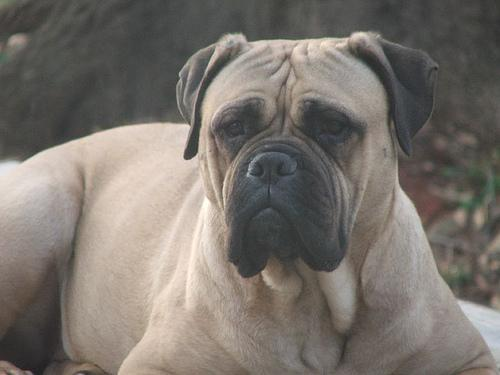

In [14]:
from IPython.display import display, HTML

def display_image(df: pd.DataFrame, idx: int) -> None:
    img_b64 = df["img_b64"].iloc[idx]
    label = df["breed"].iloc[idx]
    display(HTML(f'{label}'))
    display(HTML(f'<img src="{img_b64}" width="300" />'))

display_image(train_df, idx=1000)

## Test classification task with multimodal model (with gpt-4o 2024-08-06)

Here we will test the multimodal model with with a simple and light system prompt on our dog breed classification task. 

We will pick up a random image from the test set and display it, then we will call the multimodal model with the image and a system prompt to classify the image.

**Note**: For the sake of cost management, we will set the "detail" parameter to "low" in the image_url object. Setting the "detail" parameter to "low" costs a fixed price of 85 input tokens per image, regardless of the input size. This will reduce the image resolution and thus the cost of the request. 

Know more of how OpenAI tokenizes images and how to use the "detail" parameter in the [OpenAI documentation](https://platform.openai.com/docs/guides/images-vision?api-mode=chat#gpt_4o_gpt_4_1_gpt_4o_mini_cua_and_o_series_except_o4_mini_).

Classifying image 434 with label: Pembroke



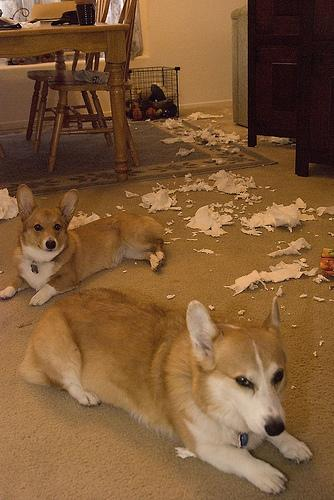

The dog breed in the image is a Pembroke Welsh Corgi.


In [15]:
import random

def classification_random_image(df: pd.DataFrame) -> str:
    """
    Function to classify a dog breed with a random image from a dataframe using the multimodal model.

    Returns:
        str: The predicted breed label.
    """
    idx = random.randint(0, len(df) - 1)
    img_b64 = df["img_b64"].iloc[idx]
    label = df["breed"].iloc[idx]

    print(f"Classifying image {idx} with label: {label}")
    display_image(df, idx)
    
    # Call the multimodal model with the image
    response = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=[
            {
                "role": "system",
                "content": "Classify the dog breed in the image."
            },
            {
                "role": "user",
                "content": [
                    { "type": "image_url",
                        "image_url": {
                            "url": img_b64,
                            "detail": "low"
                        },
                    }
                ]
            },
        ],
        max_tokens=50,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

# Test on the test set
print(classification_random_image(test_df))

# Test zero-shot classification

Narrowing down using zero-shot classification prompting technique. Introducing also the expected output format for the model response using Pydantic library.

Read more on zero-shot classification: https://huggingface.co/tasks/zero-shot-classification

In [22]:
from pydantic import BaseModel

class BreedClassifierOutput(BaseModel):
    label: str

breeds = [*test_df["breed"].unique()]

classification_prompt = f"""
Classify the following input image into one of the following categories: [{', '.join(breeds)}].
- Output your result using exclusively the following schema: {BreedClassifierOutput.model_fields}
- Put your results between a json tag
  ```json
  ```
""".strip()

print(classification_prompt)

Classify the following input image into one of the following categories: [Affenpinscher, Afghan Hound, African Hunting Dog, Airedale, American Staffordshire Terrier, Appenzeller, Australian Terrier, Basenji, Basset, Beagle, Bedlington Terrier, Bernese Mountain Dog, Black-And-Tan Coonhound, Blenheim Spaniel, Bloodhound, Bluetick, Border Collie, Border Terrier, Borzoi, Boston Bull, Bouvier Des Flandres, Boxer, Brabancon Griffon, Briard, Brittany Spaniel, Bull Mastiff, Cairn, Cardigan, Chesapeake Bay Retriever, Chihuahua, Chow, Clumber, Cocker Spaniel, Collie, Curly-Coated Retriever, Dandie Dinmont, Dhole, Dingo, Doberman, English Foxhound, English Setter, English Springer, Entlebucher, Eskimo Dog, Flat-Coated Retriever, French Bulldog, German Shepherd, German Short-Haired Pointer, Giant Schnauzer, Golden Retriever, Gordon Setter, Great Dane, Great Pyrenees, Greater Swiss Mountain Dog, Groenendael, Ibizan Hound, Irish Setter, Irish Terrier, Irish Water Spaniel, Irish Wolfhound, Italian Gr

Classifying image 577 with label: Welsh Springer Spaniel



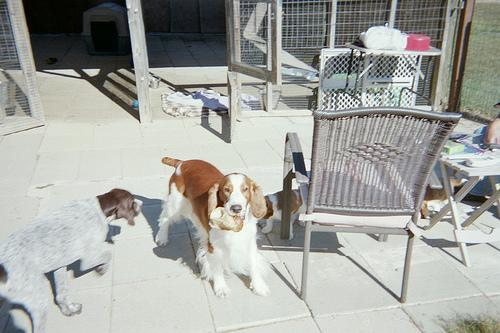

```json
{
  "label": "Welsh Springer Spaniel"
}
```


In [21]:
def zero_shot_classification_random_image(df: pd.DataFrame) -> str:
    """
    Function to classify a dog breed with a random image from a dataframe using the multimodal model.

    Returns:
        str: The predicted breed label.
    """
    idx = random.randint(0, len(test_df) - 1)
    img_b64 = df["img_b64"].iloc[idx]
    label = df["breed"].iloc[idx]

    print(f"Classifying image {idx} with label: {label}")
    display_image(df, idx)
    
    # Call the multimodal model with the image
    response = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=[
            {
                "role": "system",
                "content": classification_prompt
            },
            {
                "role": "user",
                "content": [
                    { "type": "image_url",
                        "image_url": {
                            "url": img_b64,
                            "detail": "low"
                        },
                    }
                ]
            },
        ],
        max_tokens=50,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

# Test the zero-shot classification on a random image from the test set
print(zero_shot_classification_random_image(test_df))

We can observe decent performance with the zero-shot classification approach. But let's see how it performs at scale on the test test. 

To do so, we will use the Azure OpenAI Batch API for cost optimization. The Batch API processes asynchronous groups of requests with separate quota, with 24-hour target turnaround, at 50% less cost than global standard.

### Let's format our test dataset for Batch API inference

In [36]:
def create_batch_classification_jsonl(
    df: pd.DataFrame,
    output_jsonl: str,
    deployment_name: str,
) -> None:
    """
    Create a batch classification JSONL file for the given DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'breed' and 'img_b64' columns.
        output_jsonl (str): Path to the output JSONL file.
        deployment_name (str): The Azure OpenAI deployment name for batch processing.
    """

    batch_classification_prompt = f"""
    Classify the following input image into one of the following categories: [{', '.join(breeds)}].
    """.strip()

    rows = []
    for idx, row in df.iterrows():
        # true_breed = row["breed"]
        id = row["id"]
        b64 = row["img_b64"]

        body = {
            "model": deployment_name,
            "messages": [
                {"role": "system", "content": batch_classification_prompt},
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": b64,
                                "detail": "low"
                            }
                        }
                    ],
                },
            ],
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "BreedClassifierOutput",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {
                            "breed": {"type": "string"}
                        },
                        "required": ["breed"],
                        "additionalProperties": False,
                    },
                },
            },
        }

        rows.append({
            "custom_id": str(id),
            "method": "POST",
            "url": "/chat/completions",
            "body": body
        })

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_jsonl), exist_ok=True)

    with open(output_jsonl, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

    print(f"Created batch JSONL with {len(rows)} entries at {output_jsonl}")

# Create the batch classification JSONL file
create_batch_classification_jsonl(
    test_df,
    output_jsonl="./jsonl/test_classification.jsonl",
    deployment_name=os.getenv("AZURE_OPENAI_BATCH_DEPLOYMENT_NAME"),
)

Created batch JSONL with 600 entries at ./jsonl/test_classification.jsonl


### Upload batch file

In [37]:
from datetime import datetime

file = client.files.create(
  file=open("jsonl/test_classification.jsonl", "rb"), 
  purpose="batch",
  extra_body={"expires_after":{"seconds": 1209600, "anchor": "created_at"}} # Optional you can set to a number between 1209600-2592000. This is equivalent to 14-30 days
)

print(file.model_dump_json(indent=2))

print(f"File expiration: {datetime.fromtimestamp(file.expires_at) if file.expires_at is not None else 'Not set'}")

file_id = file.id

{
  "id": "file-73e1f051c3c74d13b9cd3f06db688688",
  "bytes": 32298658,
  "created_at": 1757494957,
  "filename": "test_classification.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "expires_at": 1758704557,
  "status_details": null
}
File expiration: 2025-09-24 10:02:37


### Submit a batch job with the file

In [38]:
batch_response = client.batches.create(
    input_file_id=file_id,
    endpoint="/chat/completions",
    completion_window="24h",
    extra_body={"output_expires_after":{"seconds": 1209600, "anchor": "created_at"}} # Optional you can set to a number between 1209600-2592000. This is equivalent to 14-30 days
)

# Save batch ID for later use
batch_id = batch_response.id

print(batch_response.model_dump_json(indent=2))

{
  "id": "batch_f9426a21-b3be-4bdd-9b01-21084036f03d",
  "completion_window": "24h",
  "created_at": 1757494976,
  "endpoint": "/v1/chat/completions",
  "input_file_id": "file-73e1f051c3c74d13b9cd3f06db688688",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": "",
  "errors": null,
  "expired_at": null,
  "expires_at": 1757581376,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": "",
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  }
}


### Track batch job progress

In [39]:
import time

status = "validating"
while status not in ("completed", "failed", "canceled"):
    time.sleep(60)
    batch_response = client.batches.retrieve(batch_id)
    status = batch_response.status
    print(f"{datetime.now()} Batch Id: {batch_id},  Status: {status}")

if batch_response.status == "failed":
    for error in batch_response.errors.data:  
        print(f"Error code {error.code} Message {error.message}")

clear_output()

### Retrieve batch job output file

In [40]:
from io import StringIO

output_file_id = batch_response.output_file_id

if not output_file_id:
    output_file_id = batch_response.error_file_id

if output_file_id:
    file_response = client.files.content(output_file_id)
    json_io = StringIO(file_response.text)
    results_df = pd.read_json(json_io, lines=True)

results_df

,custom_id,response,error
0,8,{'body': {'choices': [{'content_filter_results...,NaN
1,4,{'body': {'choices': [{'content_filter_results...,NaN
2,10,{'body': {'choices': [{'content_filter_results...,NaN
3,2,{'body': {'choices': [{'content_filter_results...,NaN
4,16,{'body': {'choices': [{'content_filter_results...,NaN
...,...,...,...
595,372,{'body': {'choices': [{'content_filter_results...,NaN
596,360,{'body': {'choices': [{'content_filter_results...,NaN
597,338,{'body': {'choices': [{'content_filter_results...,NaN
598,371,{'body': {'choices': [{'content_filter_results...,NaN


Now let's parse the output file and store predictions in a pandas dataframe

In [41]:
import json

parsed_results_df = results_df.copy()

parsed_results_df[f"predicted_{os.getenv('AZURE_OPENAI_BATCH_DEPLOYMENT_NAME_MODEL_VERSION')}"] = results_df['response'].apply(
    lambda r: json.loads(
        r['body']['choices'][0]['message']['content']
    )['breed']
)

parsed_results_df = (
    parsed_results_df.sort_values("custom_id")
    .reset_index(drop=True)
    [["custom_id", f"predicted_{os.getenv('AZURE_OPENAI_BATCH_DEPLOYMENT_NAME_MODEL_VERSION')}"]]
)

parsed_results_df

,custom_id,predicted_gpt-4o-2024-08-06
0,0,Affenpinscher
1,1,Affenpinscher
2,2,Affenpinscher
3,3,Brabancon Griffon
4,4,Affenpinscher
...,...,...
595,595,Yorkshire Terrier
596,596,Yorkshire Terrier
597,597,Yorkshire Terrier
598,598,Norfolk Terrier


### Let's compare the base model predictions with the true breed labels (ground truth)

In [42]:
comparison_df = test_df.copy()
comparison_df["custom_id"] = comparison_df.reset_index(drop=False)["index"]
comparison_df = comparison_df.merge(parsed_results_df)
comparison_df.head()

,id,breed,img_b64,custom_id,predicted_gpt-4o-2024-08-06
0,0,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",0,Affenpinscher
1,1,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",1,Affenpinscher
2,2,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",2,Affenpinscher
3,3,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",3,Brabancon Griffon
4,4,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",4,Affenpinscher


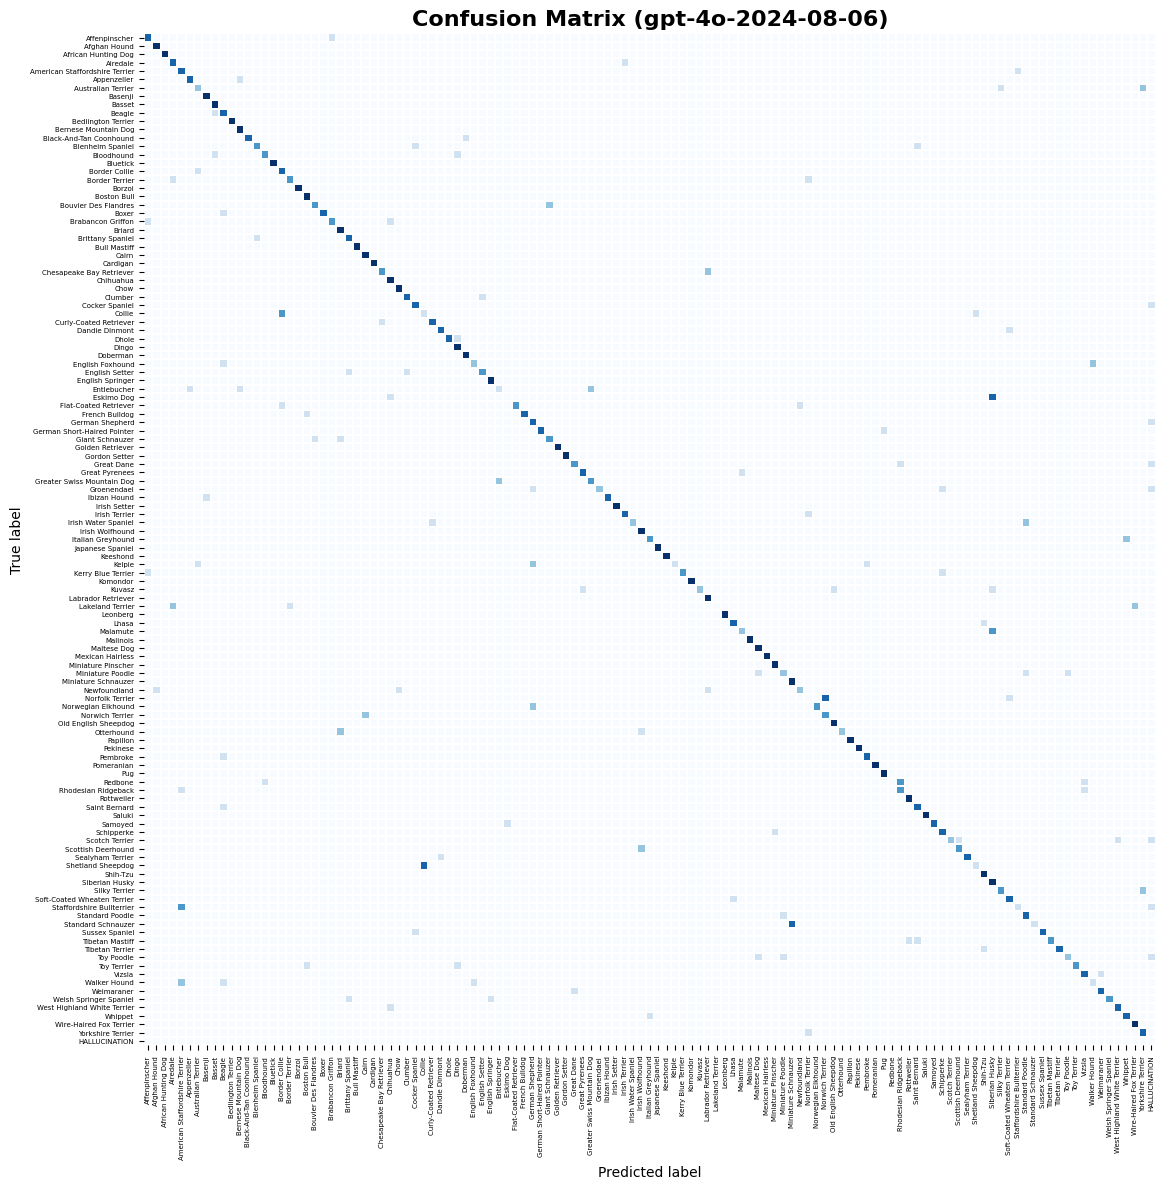

Classification Report:
                                precision    recall  f1-score   support

                 Affenpinscher       0.67      0.80      0.73         5
                  Afghan Hound       0.83      1.00      0.91         5
           African Hunting Dog       1.00      1.00      1.00         5
                      Airedale       0.57      0.80      0.67         5
American Staffordshire Terrier       0.40      0.80      0.53         5
                   Appenzeller       0.80      0.80      0.80         5
            Australian Terrier       0.50      0.40      0.44         5
                       Basenji       0.83      1.00      0.91         5
                        Basset       0.71      1.00      0.83         5
                        Beagle       0.44      0.80      0.57         5
            Bedlington Terrier       1.00      1.00      1.00         5
          Bernese Mountain Dog       0.71      1.00      0.83         5
       Black-And-Tan Coonhound       1.0

c:\Users\alevret\OneDrive - Microsoft\Documents\DN\Code\vlm-image-classification-ft\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alevret\OneDrive - Microsoft\Documents\DN\Code\vlm-image-classification-ft\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\alevret\OneDrive - Microsoft\Documents\DN\Code\vlm-image-classification-ft\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels w

In [43]:
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique breeds from the test set
unique_breeds = sorted(comparison_df["breed"].unique())

y_true = list(comparison_df["breed"])
y_pred = [
    label if label in unique_breeds else "HALLUCINATION"
    for label in comparison_df[f"predicted_{os.getenv('AZURE_OPENAI_BATCH_DEPLOYMENT_NAME_MODEL_VERSION')}"]
]

labels = unique_breeds + ["HALLUCINATION"]

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

n = len(labels)
cell_size = 0.2         
max_dim   = 12          

fig_w = min(max_dim, max(8, n * cell_size))
fig_h = min(max_dim, max(6, n * cell_size))

plt.figure(figsize=(fig_w, fig_h), dpi=100)
sns.heatmap(
    cm,
    cmap="Blues",
    cbar=False,      
    square=True,
    xticklabels=labels,
    yticklabels=labels,
    annot=False,
    linewidths=0.1
)

plt.title(
    f"Confusion Matrix ({os.getenv('AZURE_OPENAI_BATCH_DEPLOYMENT_NAME_MODEL_VERSION')})",
    fontsize=16,
    fontweight="bold"
)
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.xticks(rotation=90, fontsize=5)
plt.yticks(rotation=0,  fontsize=5)

plt.tight_layout()
plt.show()
# ---- end plotting ----

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


# Let's compare the base model performance with a fine-tuned version of the model

Let's format our train and validation datasets for fine-tuning

In [72]:
def create_fine_tuning_batch_classification_jsonl(
    df: pd.DataFrame,
    output_jsonl: str,
    deployment_name: str,
) -> None:
    """
    Create a fine-tuning batch classification JSONL file based on a dataset.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'id', 'img_b64' and 'breed' columns.
        output_jsonl (str): Path to the output JSONL file.
        deployment_name (str): The Azure OpenAI deployment name for batch processing.
    """

    batch_classification_prompt = f"""
    Classify the following input image into one of the following categories: [{', '.join(breeds)}].
    """.strip()

    rows = []
    for idx, row in df.iterrows():
        id = row["id"]
        b64 = row["img_b64"]
        breed = row["breed"]

        messages = {
            "messages": [
                {
                    "role": "system", 
                    "content": batch_classification_prompt
                },
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": b64,
                                "detail": "low"
                            }
                        }
                    ],
                },
                {
                    "role": "assistant", 
                    "content": breed
                }
            ]
        }

        rows.append(messages)

    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(output_jsonl), exist_ok=True)

    with open(output_jsonl, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

    print(f"Created batch JSONL with {len(rows)} entries at {output_jsonl}")

# Create the training JSONL file
create_fine_tuning_batch_classification_jsonl(
    train_df,
    output_jsonl="./jsonl/train_classification.jsonl",
    deployment_name=os.getenv("AZURE_OPENAI_BATCH_DEPLOYMENT_NAME"),
)

# Create the validation JSONL file
create_fine_tuning_batch_classification_jsonl(
    val_df,
    output_jsonl="./jsonl/val_classification.jsonl",
    deployment_name=os.getenv("AZURE_OPENAI_BATCH_DEPLOYMENT_NAME"),
)

Created batch JSONL with 4800 entries at ./jsonl/train_classification.jsonl
Created batch JSONL with 600 entries at ./jsonl/val_classification.jsonl
Created batch JSONL with 600 entries at ./jsonl/val_classification.jsonl


In [73]:
# Upload the training and validation dataset files to Azure OpenAI with the SDK.

training_file_name = './jsonl/train_classification.jsonl'
validation_file_name = './jsonl/val_classification.jsonl'

training_response = client.files.create(
    file=open(training_file_name, "rb"), purpose="fine-tune"
)
training_file_id = training_response.id

validation_response = client.files.create(
    file=open(validation_file_name, "rb"), purpose="fine-tune"
)
validation_file_id = validation_response.id

print("Training file ID:", training_file_id)
print("Validation file ID:", validation_file_id)

Training file ID: file-2d365bb856314bb7a9bf3a74cd8be067
Validation file ID: file-dd31ed450b564d95953bbf9150d7d7d8


Launch fine-tuning job

In [74]:
# specify hyperparameters for the fine-tuning job

response = client.fine_tuning.jobs.create(
    training_file=training_file_id,
    validation_file=validation_file_id,
    model="gpt-4o-2024-08-06", 
    seed=42,
    hyperparameters={
        "n_epochs": 2, # We limit the number of epochs to 2 for cost management purposes.
        "learning_rate_multiplier": 0.5, # Adjust learning rate for better convergence
    }
)

job_id = response.id

print("Job ID:", job_id)
print(response.model_dump_json(indent=2))

Job ID: ftjob-46fe1c4edca240248803a9e7ccbbb105
{
  "id": "ftjob-46fe1c4edca240248803a9e7ccbbb105",
  "created_at": 1757429132,
  "error": null,
  "fine_tuned_model": null,
  "finished_at": null,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 0.5,
    "n_epochs": 2
  },
  "model": "gpt-4o-2024-08-06",
  "object": "fine_tuning.job",
  "organization_id": null,
  "result_files": null,
  "seed": 42,
  "status": "pending",
  "trained_tokens": null,
  "training_file": "file-2d365bb856314bb7a9bf3a74cd8be067",
  "validation_file": "file-dd31ed450b564d95953bbf9150d7d7d8",
  "estimated_finish": 1757486660,
  "integrations": null,
  "metadata": null,
  "method": null
}


Once the fine-tuning job is completed, we can retrieve the fine-tuned model deployment name from the Azure AI Foundry portal or using the Azure CLI.

Go on the Azure AI Foundry portal, select your newly created fine-tuning job, then click on the "Use this model" tab. It will ask you for a deployment type (regional or global), and the tokens per minute (TPM) you want to allocate for this deployment.

Classifying image 184 with label: Dhole



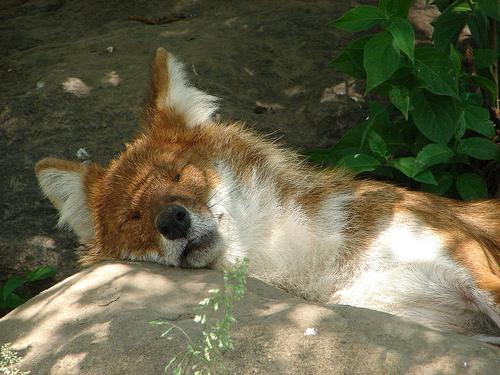

```json
{"label": "Dhole"}
```


In [25]:
def ft_zero_shot_classification_random_image(df: pd.DataFrame) -> str:
    """
    Function to classify a dog breed with a random image from a dataframe using the multimodal model.

    Returns:
        str: The predicted breed label.
    """
    idx = random.randint(0, len(test_df) - 1)
    img_b64 = df["img_b64"].iloc[idx]
    label = df["breed"].iloc[idx]

    print(f"Classifying image {idx} with label: {label}")
    display_image(df, idx)

    FT_DEPLOYMENT = os.getenv("AZURE_OPENAI_FT_DEPLOYMENT_NAME") or "gpt-4o-2024-08-06-ft"
    
    # Call the multimodal model with the image
    response = client.chat.completions.create(
        model=FT_DEPLOYMENT,
        messages=[
            {
                "role": "system",
                "content": classification_prompt
            },
            {
                "role": "user",
                "content": [
                    { "type": "image_url",
                        "image_url": {
                            "url": img_b64,
                            "detail": "low"
                        },
                    }
                ]
            },
        ],
        max_tokens=50,
        seed=42,
        temperature=0
    )
    return response.choices[0].message.content

# Test the zero-shot classification on a random image from the test set
print(ft_zero_shot_classification_random_image(test_df))

# Evaluate fine-tuned model and run Batch inference on test set

We will:
- Try the fine-tuned model on a random image from the test set
- Run Batch API inference on the entire test set with the fine-tuned deployment
- Download and parse predictions
- Evaluate and compare base vs. fine-tuned performance

[FT] Classifying image 449 with label: Redbone



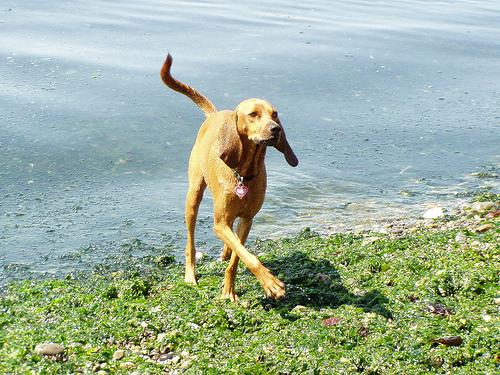

```json
{"label":"Vizsla"}
```


In [26]:
# 1) Try the fine-tuned model on a random image from the test set
import os

FT_DEPLOYMENT = os.getenv("AZURE_OPENAI_FT_DEPLOYMENT_NAME") or "gpt-4o-2024-08-06-ft"

def ft_classification_random_image(df: pd.DataFrame) -> str:
    """
    Classify a random dog image using the fine-tuned deployment.
    """
    idx = random.randint(0, len(df) - 1)
    img_b64 = df["img_b64"].iloc[idx]
    label = df["breed"].iloc[idx]

    print(f"[FT] Classifying image {idx} with label: {label}")
    display_image(df, idx)

    response = client.chat.completions.create(
        model=FT_DEPLOYMENT,
        messages=[
            {"role": "system", "content": classification_prompt},
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": img_b64, "detail": "low"},
                    }
                ],
            },
        ],
        max_tokens=50,
        seed=42,
        temperature=0,
    )
    return response.choices[0].message.content

print(ft_classification_random_image(test_df))

In [27]:
# 2) Prepare JSONL input for the fine-tuned model

def create_batch_classification_jsonl_ft(
    df: pd.DataFrame,
    output_jsonl: str,
    deployment_name: str,
) -> None:
    batch_classification_prompt = f"""
    Classify the following input image into one of the following categories: [{', '.join(breeds)}].
    """.strip()

    rows = []
    for _, row in df.iterrows():
        id = row["id"]
        b64 = row["img_b64"]

        body = {
            "model": deployment_name,
            "messages": [
                {"role": "system", "content": batch_classification_prompt},
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "image_url",
                            "image_url": {"url": b64, "detail": "low"},
                        }
                    ],
                },
            ],
            "response_format": {
                "type": "json_schema",
                "json_schema": {
                    "name": "BreedClassifierOutput",
                    "strict": True,
                    "schema": {
                        "type": "object",
                        "properties": {"breed": {"type": "string"}},
                        "required": ["breed"],
                        "additionalProperties": False,
                    },
                },
            },
        }

        rows.append(
            {
                "custom_id": str(id),
                "method": "POST",
                "url": "/chat/completions",
                "body": body,
            }
        )

    Path(Path(output_jsonl).parent).mkdir(parents=True, exist_ok=True)
    with open(output_jsonl, "w", encoding="utf-8") as f:
        for r in rows:
            f.write(json.dumps(r) + "\n")

    print(f"Created FT JSONL with {len(rows)} entries at {output_jsonl}")

create_batch_classification_jsonl_ft(
    test_df,
    output_jsonl="./jsonl/test_classification_ft.jsonl",
    deployment_name=FT_DEPLOYMENT,
)

Created FT JSONL with 600 entries at ./jsonl/test_classification_ft.jsonl


### Actually the Batch API doesn't support currently the usage of a fine-tuned model. 
Let's use the fine-tuned model in a loop instead to classify the entire test set.

In [29]:
ft_classification_prompt = f"""
Classify the following input image into one of the following categories: [{', '.join(breeds)}].
""".strip()

ft_predictions = []
for _, row in test_df.iterrows():
    id = row["id"]
    b64 = row["img_b64"]
    label = row["breed"]

    response = client.chat.completions.create(
        model=FT_DEPLOYMENT,
        messages=[
            {"role": "system", "content": ft_classification_prompt},
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": b64, "detail": "low"},
                    }
                ],
            },
        ],
        max_tokens=50,
        seed=42,
        temperature=0,
    )
    pred = response.choices[0].message.content
    ft_predictions.append({"id": id, "predicted_label": pred})

In [30]:
# 3) Parse FT outputs 
ft_parsed_results_df = pd.DataFrame(ft_predictions)
ft_parsed_results_df = (
    ft_parsed_results_df.sort_values("id")
    .reset_index(drop=True)
)
ft_parsed_results_df

,id,predicted_label
0,0,Affenpinscher
1,1,Affenpinscher
2,2,Affenpinscher
3,3,Affenpinscher
4,4,Affenpinscher
...,...,...
595,595,Yorkshire Terrier
596,596,Yorkshire Terrier
597,597,Yorkshire Terrier
598,598,Norfolk Terrier


## Now let's compare the fine-tuned model predictions with the true breed labels (ground truth)

In [31]:
# 4) Parse FT predictions robustly and merge with the test set
import re, json
from sklearn.metrics import accuracy_score, balanced_accuracy_score

# Ensure the FT parsed results dataframe exists
try:
    ft_parsed_results_df
except NameError:
    raise NameError("ft_parsed_results_df not found. Make sure the FT prediction loop has been run and ft_parsed_results_df is available.")

def _parse_ft_pred(pred):
    """Try to extract a single breed string from a free-form FT response."""
    if pred is None:
        return None
    if not isinstance(pred, str):
        pred = str(pred)
    text = pred.strip()
    # Remove markdown/json fences if present
    m = re.search(r'```json(.*?)```', text, re.S)
    if m:
        candidate = m.group(1).strip()
        try:
            obj = json.loads(candidate)
            return obj.get('breed') or obj.get('label') or str(obj)
        except Exception:
            text = candidate
    # Try to find a JSON object anywhere in the text
    m = re.search(r'.*', text, re.S)
    if m:
        try:
            obj = json.loads(m.group(0))
            return obj.get('breed') or obj.get('label') or str(obj)
        except Exception:
            pass
    # Fall back to a simple heuristic: take first non-empty line
    line = text.splitlines()[0].strip() if text.splitlines() else text
    # If line looks like key: value, return the value
    if ':' in line:
        parts = line.split(':', 1)
        return parts[1].strip().strip('"\'')
    # else return the cleaned line
    return line.strip().strip('"\'')

# Create a parsed column
ft_parsed_results_df['predicted_label_parsed'] = ft_parsed_results_df['predicted_label'].apply(_parse_ft_pred)

# Merge with test_df on 'id' (cast to str to be safe)
comparison_ft_df = test_df.copy()
# Some versions of test_df have numeric id, others string - normalize to str
if 'id' not in comparison_ft_df.columns:
    # If original index was used, create id from index
    comparison_ft_df = comparison_ft_df.reset_index().rename(columns={'index': 'id'})
comparison_ft_df['id'] = comparison_ft_df['id'].astype(str)
ft_parsed_results_df['id'] = ft_parsed_results_df['id'].astype(str)
comparison_ft_df = comparison_ft_df.merge(ft_parsed_results_df.rename(columns={'id': 'id'}), on='id', how='left')

# Quick check
print(f'Merged rows: {len(comparison_ft_df)}, missing FT preds: {comparison_ft_df['predicted_label_parsed'].isna().sum()}')
comparison_ft_df.head()

Merged rows: 600, missing FT preds: 0


,id,breed,img_b64,predicted_label,predicted_label_parsed
0,0,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",Affenpinscher,Affenpinscher
1,1,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",Affenpinscher,Affenpinscher
2,2,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",Affenpinscher,Affenpinscher
3,3,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",Affenpinscher,Affenpinscher
4,4,Affenpinscher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA...",Affenpinscher,Affenpinscher


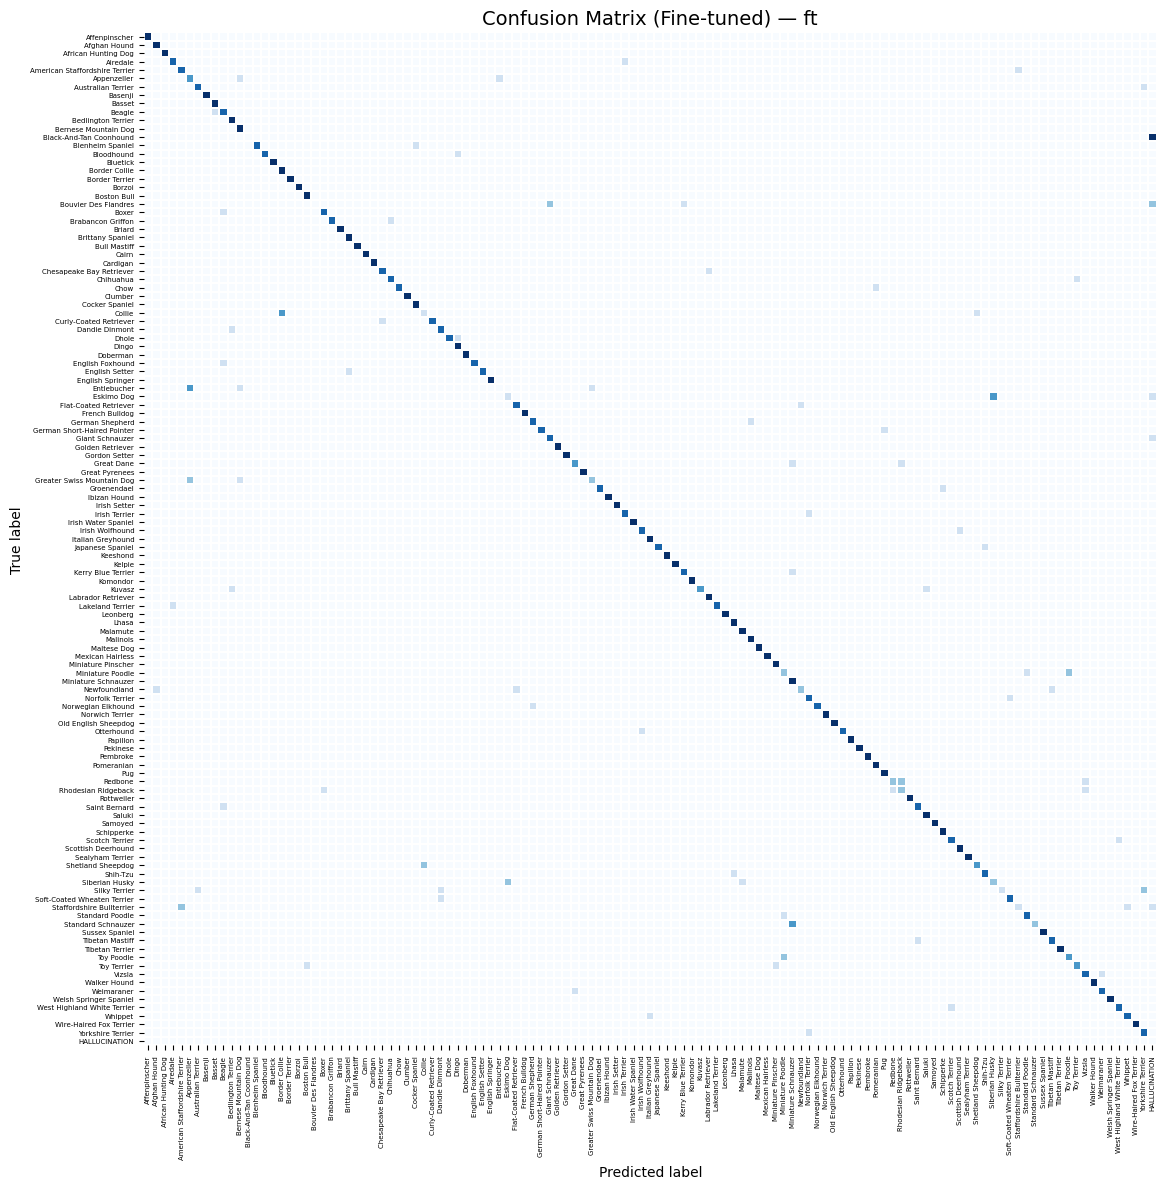

Accuracy: 0.8266666666666667
Balanced accuracy: 0.8266666666666668

Classification Report:
                                precision    recall  f1-score   support

                 Affenpinscher       1.00      1.00      1.00         5
                  Afghan Hound       0.83      1.00      0.91         5
           African Hunting Dog       1.00      1.00      1.00         5
                      Airedale       0.80      0.80      0.80         5
American Staffordshire Terrier       0.67      0.80      0.73         5
                   Appenzeller       0.38      0.60      0.46         5
            Australian Terrier       0.80      0.80      0.80         5
                       Basenji       1.00      1.00      1.00         5
                        Basset       0.83      1.00      0.91         5
                        Beagle       0.57      0.80      0.67         5
            Bedlington Terrier       0.71      1.00      0.83         5
          Bernese Mountain Dog       0.62   

c:\Users\alevret\OneDrive - Microsoft\Documents\DN\Code\vlm-image-classification-ft\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [32]:
# 5) Compute confusion matrix and classification report for the FT model
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

unique_breeds = sorted(comparison_ft_df['breed'].unique())
y_true = list(comparison_ft_df['breed'])
# Use parsed prediction; if missing, mark as HALLUCINATION
raw_preds = list(comparison_ft_df['predicted_label_parsed'].fillna(''))
y_pred = [p if p in unique_breeds else 'HALLUCINATION' for p in raw_preds]
labels = unique_breeds + ['HALLUCINATION']

cm = confusion_matrix(y_true, y_pred, labels=labels)
n = len(labels)
cell_size = 0.2
max_dim = 12
fig_w = min(max_dim, max(8, n * cell_size))
fig_h = min(max_dim, max(6, n * cell_size))
plt.figure(figsize=(fig_w, fig_h), dpi=100)
sns.heatmap(cm, cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels, annot=False, linewidths=0.1)
plt.title(f'Confusion Matrix (Fine-tuned) — {os.getenv('AZURE_OPENAI_FT_BATCH_DEPLOYMENT_NAME_MODEL_VERSION', 'ft')}', fontsize=14)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=90, fontsize=5)
plt.yticks(rotation=0, fontsize=5)
plt.tight_layout()
plt.show()

print('Accuracy:', accuracy_score(y_true, y_pred))
print('Balanced accuracy:', balanced_accuracy_score(y_true, y_pred))
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=labels, zero_division=0))

In [33]:
# 6) Show top mismatches to inspect common errors
mismatches = comparison_ft_df[comparison_ft_df['breed'] != comparison_ft_df['predicted_label_parsed'].fillna('')].copy()
# Show a small sample of mismatches with true / pred / image
from IPython.display import HTML, display
display_cols = ['id', 'breed', 'predicted_label_parsed', 'img_b64'] if 'img_b64' in comparison_ft_df.columns else ['id', 'breed', 'predicted_label_parsed']
print(f'Total mismatches: {len(mismatches)}')
if len(mismatches):
    display(mismatches[display_cols].head(10))
else:
    print('No mismatches found — FT predictions match ground truth for all test examples (unexpected).')

Total mismatches: 104


,id,breed,predicted_label_parsed,img_b64
18,18,Airedale,Irish Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
21,21,American Staffordshire Terrier,Staffordshire Bullterrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
25,25,Appenzeller,Entlebucher,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
28,28,Appenzeller,Bernese Mountain Dog,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
33,33,Australian Terrier,Yorkshire Terrier,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
49,49,Beagle,Basset,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
60,60,Black-And-Tan Coonhound,,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
61,61,Black-And-Tan Coonhound,,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
62,62,Black-And-Tan Coonhound,,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."
63,63,Black-And-Tan Coonhound,,"data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQA..."


## Per-class accuracy comparison (Base vs Fine-tuned)

The following cells compute, tabulate, and visualize per-breed (class) accuracies for:
- Base model batch predictions
- Fine-tuned model predictions

Metrics displayed:
- support: number of test samples for that breed
- base_accuracy: accuracy of the base model for the breed
- ft_accuracy: accuracy of the fine-tuned model for the breed
- delta_ft_minus_base: improvement (positive means fine-tuned > base)

A bar chart is also produced to compare accuracies side-by-side. If either the base or fine-tuned prediction DataFrames are missing (e.g. earlier cells not executed), an error will be raised.

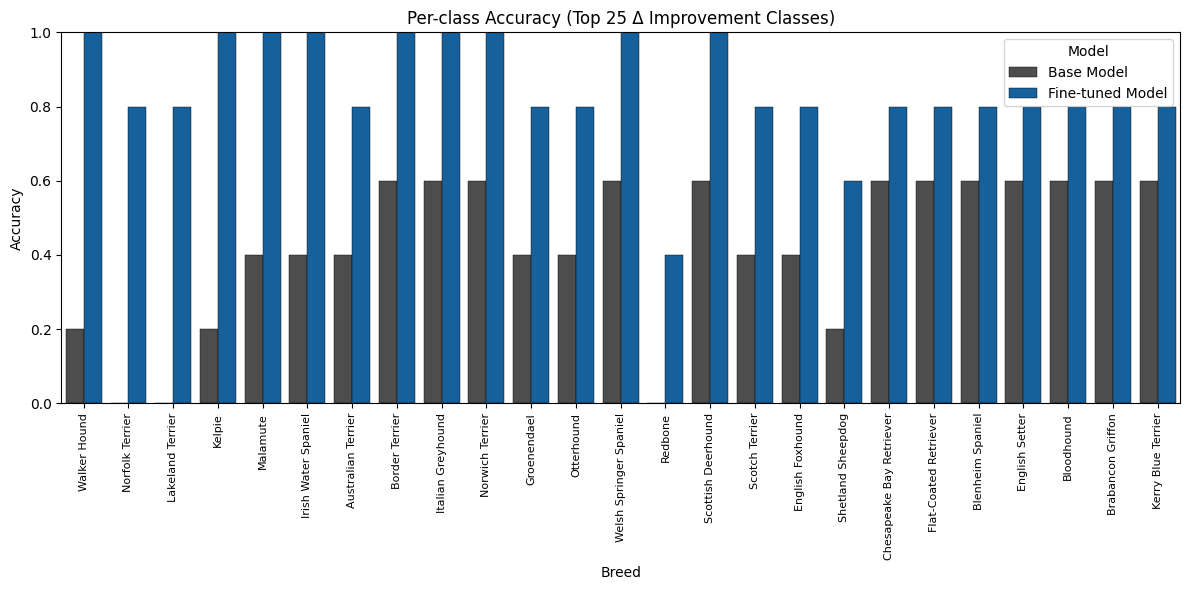

Mean base accuracy: 73.67%
Mean fine-tuned accuracy: 82.67%
Mean improvement (FT - Base): +9.00%


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# --- Preconditions & retrieval of needed dataframes ---
_base_pred_col = None
if 'comparison_df' not in globals():
    raise NameError("comparison_df not found. Run the base model batch inference section first.")
else:
    for c in comparison_df.columns:
        if c.startswith('predicted_'):
            _base_pred_col = c
            break
    if _base_pred_col is None:
        raise ValueError("Could not locate base prediction column (expected a column starting with 'predicted_').")

if 'comparison_ft_df' not in globals():
    raise NameError("comparison_ft_df not found. Run the fine-tuned inference section first.")
if 'predicted_label_parsed' not in comparison_ft_df.columns:
    raise ValueError("'predicted_label_parsed' column missing in comparison_ft_df. Ensure parsing cell executed.")

# --- Build per-class accuracy statistics ---
base_records = []
ft_records = []

for breed, grp in comparison_df.groupby('breed'):
    support = len(grp)
    correct = (grp['breed'] == grp[_base_pred_col]).sum()
    acc = correct / support if support else np.nan
    base_records.append({'breed': breed, 'support': support, 'base_accuracy': acc})
base_acc_df = pd.DataFrame(base_records)

for breed, grp in comparison_ft_df.groupby('breed'):
    support = len(grp)
    correct = (grp['breed'] == grp['predicted_label_parsed']).sum()
    acc = correct / support if support else np.nan
    ft_records.append({'breed': breed, 'support_ft': support, 'ft_accuracy': acc})
ft_acc_df = pd.DataFrame(ft_records)

per_class_df = base_acc_df.merge(ft_acc_df, on='breed', how='outer')
per_class_df['support'] = per_class_df['support'].fillna(per_class_df['support_ft'])
per_class_df = per_class_df.drop(columns=['support_ft'])
per_class_df['delta_ft_minus_base'] = per_class_df['ft_accuracy'] - per_class_df['base_accuracy']
per_class_df = per_class_df.sort_values('delta_ft_minus_base', ascending=False).reset_index(drop=True)

# (Removed dataframe HTML display per user request)

# --- Visualization (breeds on X-axis) ---
TOP_N = 25
plot_df = per_class_df.head(TOP_N).copy()
plot_df = plot_df.reset_index(drop=True)

melt_df = plot_df.melt(id_vars=['breed'], value_vars=['base_accuracy', 'ft_accuracy'], var_name='model', value_name='accuracy')

# Distinctive palette: dark charcoal for base, bright Azure accent for FT
custom_palette = {
    'base_accuracy': '#4D4D4D',   # dark neutral gray
    'ft_accuracy': '#0063B1'      # vivid azure (Windows accent)
}

fig_w = max(12, 0.4 * len(plot_df))
plt.figure(figsize=(fig_w, 6))
bar_ax = sns.barplot(data=melt_df, x='breed', y='accuracy', hue='model', palette=custom_palette, edgecolor='black', linewidth=0.3)

plt.title(f'Per-class Accuracy (Top {TOP_N} Δ Improvement Classes)')
plt.ylabel('Accuracy')
plt.xlabel('Breed')
plt.ylim(0, 1)
plt.xticks(rotation=90, ha='center', fontsize=8)

# Replace legend labels with cleaner text
handles, labels = bar_ax.get_legend_handles_labels()
label_map = {'base_accuracy': 'Base Model', 'ft_accuracy': 'Fine-tuned Model'}
plt.legend([h for h in handles], [label_map.get(l, l) for l in labels], title='Model')

plt.tight_layout()
plt.show()

# Summary statistics
mean_base = per_class_df['base_accuracy'].mean()
mean_ft = per_class_df['ft_accuracy'].mean()
mean_delta = (mean_ft - mean_base)
print(f'Mean base accuracy: {mean_base:.2%}')
print(f'Mean fine-tuned accuracy: {mean_ft:.2%}')
print(f'Mean improvement (FT - Base): {mean_delta:+.2%}')